## Lab 7 - Using Machine Learning for Intrusion Detection

This Lab exercise will guide you through an example of using a machine learning (ML) algorithm to train a model for intrusion detection. You have been provided with this Notebook with markdown explanations & code used in this example, and a custom dataset that has been extracted from the NBaIoT dataset provided by UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT).

The provided dataset has labelled samples from benign traffic generated by a security camera (SimpleHome XCs7-1003-WHT) as well as traces when this camera is infected with Mirai botnet to launch a TCP SYN flooding attack. There are 115 features with one target class in the dataset. Details are in the following paper. 

[1] Y. Meidan, M. Bohadana, Y. Mathov, Y. Mirsky, D. Breitenbacher, A. Shabtai, and Y. Elovici "N-BaIoT: Network-based Detection of IoT Botnet Attacks Using Deep Autoencoders", IEEE Pervasive Computing, Special Issue - Securing the IoT (July/Sep 2018).

Attribute/Features Information:
The following describes each of the features headers:

- Stream aggregation:
   - H: ("Source IP" in N-BaIoT paper) Stats summarizing the recent traffic from this packet's host (IP)
   - MI: ("Source MAC-IP" in N-BaIoT paper) Stats summarizing the recent traffic from this packet's host (IP + MAC)
   - HH: ("Channel" in N-BaIoT paper) Stats summarizing the recent traffic going from this packet's host (IP) to the packet's destination host.
   - HH_jit: ("Channel jitter" in N-BaIoT paper) Stats summarizing the jitter of the traffic going from this packet's host (IP) to the packet's destination host.
   - HpHp: ("Socket" in N-BaIoT paper) Stats summarizing the recent traffic going from this packet's host+port (IP) to the packet's destination host+port. Example 192.168.4.2:1242 -> 192.168.4.12:80
- Time-frame (The decay factor Lambda used in the damped window): 
    - How much recent history of the stream is capture in these statistics (L5, L3, L1, L0.1 and L0.01)
- The statistics extracted from the packet stream:
   - weight: The weight of the stream (can be viewed as the number of items observed in recent history)
   - mean: ...
   - std: ...
   - radius: The root squared sum of the two streams' variances
   - magnitude: The root squared sum of the two streams' means 
   - cov: An approximated covariance between two streams
   - pcc: An approximated correlation coefficient between two streams


If you are interested in learning how these features have been extracted from the raw pcap (TCPDump or Wireshark captures), read the following paper. 

[2] Y. Mirsky, T. Doitshman, Y. Elovici & A. Shabtai 2018, "Kitsune: An Ensemble of Autoencoders for Online Network Intrusion Detection", in Network and Distributed System Security (NDSS) Symposium, San Diego, CA, USA. 

The example code in this notebook employs a simple supervised machine learning algorithm called K-Nearest Neighbor (k-NN) for classification purposes. The markdown text walks you through the ML pipeline required to train the model on the dataset, and evaluate its performance.  

You are required to create another Notebook by using a different ML algorithm called Decision Trees (DT - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You are to compare the results from using k-NN and DT on the provided dataset. Submit your DT notebook with narrative text explaining the following:

1. Compare the performance of k-NN and DT for the given classification task using accuracy, precision, recall, and latency as the metrics. 
2. Show the confusion matrix and the RoC curve 
3. Comment on performance of DT by using different values for hyperparameters (splitter, max_depth, min_samples_split, max_features) and split ratios (train:valid:test = 4:3:3, 3:1:1, 8:1:1). 

### Import Libraries, Modules and read the Dataset

In [1]:
import pandas as pd
import numpy as np   ### Support for large, multi-dimensional arrays and matrices. Has a large collection of high-level mathematical functions.
import matplotlib.pyplot as plt  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_val_score
from time import time

dataset = pd.read_csv('FinalDataset.csv')

Lets have a peek at the dataset

In [2]:
dataset.head()
#gives the first five rows of data

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
0,1.000000,74.0,0.000000e+00,1.000000,74.0,0.000000e+00,1.000000,74.0,0.000000e+00,1.000000,...,0.0,0.0,1.0,74.0,0.0,74.0,0.0,0.0,0.0,Mirai_SYN
1,1.995653,74.0,0.000000e+00,1.997390,74.0,1.820000e-12,1.999129,74.0,0.000000e+00,1.999913,...,0.0,0.0,1.0,74.0,0.0,74.0,0.0,0.0,0.0,Mirai_SYN
2,2.984032,74.0,0.000000e+00,2.990403,74.0,1.820000e-12,2.996795,74.0,9.090000e-13,2.999679,...,0.0,0.0,1.0,74.0,0.0,74.0,0.0,0.0,0.0,Mirai_SYN
3,3.952494,74.0,0.000000e+00,3.971399,74.0,1.820000e-12,3.990434,74.0,0.000000e+00,3.999042,...,0.0,0.0,1.0,74.0,0.0,74.0,0.0,0.0,0.0,Mirai_SYN
4,4.931439,74.0,9.090000e-13,4.958692,74.0,1.820000e-12,4.986173,74.0,9.090000e-13,4.998615,...,0.0,0.0,1.0,74.0,0.0,74.0,0.0,0.0,0.0,Mirai_SYN


### Explore Features

In [3]:
dataset.info()# See the distribution of our target variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39056 entries, 0 to 39055
Columns: 116 entries, MI_dir_L5_weight to Class
dtypes: float64(115), object(1)
memory usage: 34.6+ MB


In [4]:
dataset['Class'].value_counts()  #check whether it is a balanced dataset or an imbalanced dataset

Benign       19528
Mirai_SYN    19528
Name: Class, dtype: int64

In [5]:
#Get an idea about the actual data distribution
pd.options.display.float_format = '{:20,.3f}'.format
dataset.describe()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
count,"39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000",...,"39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000","39,056.000"
mean,70.569,145.774,151.178,113.910,145.738,203.423,330.944,147.771,928.338,"3,029.858",...,"2,182.203",-24.576,-0.000,5.467,146.028,2.912,191.321,"2,759.261",-133.272,-0.011
std,72.909,119.313,"1,770.355",115.984,119.088,"1,982.480",332.315,116.868,"2,945.813","3,041.787",...,"16,463.431","2,001.900",0.038,15.334,118.702,16.897,179.734,"22,582.172","4,793.291",0.107
min,1.000,60.000,0.000,1.000,60.000,0.000,1.000,60.000,0.000,1.000,...,0.000,"-37,601.681",-0.587,1.000,60.000,0.000,60.000,0.000,"-68,855.092",-1.138
25%,1.000,67.488,0.000,1.000,68.537,0.000,1.062,70.547,0.107,2.768,...,0.000,0.000,0.000,1.000,60.000,0.000,74.000,0.000,0.000,0.000
50%,21.300,72.242,4.996,21.641,71.610,14.184,22.570,71.586,34.982,49.960,...,0.000,0.000,0.000,1.000,74.000,0.000,74.000,0.000,0.000,0.000
75%,136.877,330.000,37.087,224.669,330.000,38.027,662.818,329.999,42.857,"6,201.298",...,0.000,0.000,0.000,6.275,330.000,0.000,431.490,0.000,0.000,0.000
max,251.405,670.000,"83,290.214",354.414,670.000,"89,354.113",828.257,669.565,"92,557.424","6,546.597",...,"480,808.295","69,895.058",0.707,148.749,670.000,220.179,"1,265.998","454,622.861","143,864.111",1.299


In [6]:
#Check whether there are null values
dataset.columns[dataset.isna().any()].tolist()
# dataset.isnull().sum()

## Fill any null values with the Mean value of that feature. Should make sure that null is not a acceptable value for that feature.
# dataset['MI_dir_L5_weight'].fillna(dataset['MI_dir_L5_weight'].mean(), inplace=True)


[]

In [7]:
#check for duplicates
# Select duplicate rows except first occurrence based on all columns
duplicates = dataset[dataset.duplicated()]
print(duplicates.count())

#Keep the first occurance 
# dataset.duplicated(subset=None, keep='first')

MI_dir_L5_weight         1592
MI_dir_L5_mean           1592
MI_dir_L5_variance       1592
MI_dir_L3_weight         1592
MI_dir_L3_mean           1592
                         ... 
HpHp_L0.01_magnitude     1592
HpHp_L0.01_radius        1592
HpHp_L0.01_covariance    1592
HpHp_L0.01_pcc           1592
Class                    1592
Length: 116, dtype: int64


### Split into train, validation, and test set

In [8]:
#shuffle the dataset
dataset = dataset.reindex(np.random.permutation(dataset.index))

In [9]:
#Separate Features and Labels
features = dataset.drop('Class', axis=1)
# features = dataset.iloc[:,50:80] #We can slice the dataframe and test with different feature combinations.
labels = dataset['Class']

In [10]:
features.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
38239,1.000,330.000,0.000,1.000,330.000,0.000,1.000,330.000,0.068,1.847,...,0.000,0.000,0.000,6.278,330.000,0.000,431.490,0.000,0.000,0.000
21650,1.000,330.000,0.000,1.000,330.000,0.000,1.000,330.000,0.066,1.893,...,0.000,0.000,0.000,6.272,330.000,0.000,431.490,0.000,-0.000,-0.000
16590,97.145,71.744,29.886,177.802,70.747,37.143,610.813,70.433,38.128,"6,392.139",...,0.000,0.000,0.000,1.000,74.000,0.000,74.000,0.000,0.000,0.000
24329,1.000,60.000,0.004,1.000,60.016,4.359,1.062,75.781,"4,011.941",2.942,...,0.000,-0.000,-0.000,6.285,60.000,0.000,84.853,0.000,-0.000,0.000
3443,181.960,67.323,49.150,276.713,68.767,46.429,683.682,70.005,40.705,"5,565.790",...,0.000,0.000,0.000,1.000,60.000,0.000,60.000,0.000,0.000,0.000


In [11]:
labels.head()

38239       Benign
21650       Benign
16590    Mirai_SYN
24329       Benign
3443     Mirai_SYN
Name: Class, dtype: object

In [12]:
#Split the dataset in to Training, Validation and Test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Fit and evaluate a KNN model with default values and use 5-fold Cross-Validation

In [13]:
#First lets try to make a model and evaluate it
knn = KNeighborsClassifier()
start =time()
knn0 = knn.fit(X_train, y_train)
end = time()
y_pred0 = knn0.predict(X_val)
print(y_pred0)
print('Training Latency: {}ms'.format(round((end - start)*1000, 1)))

['Mirai_SYN' 'Benign' 'Mirai_SYN' ... 'Mirai_SYN' 'Mirai_SYN' 'Mirai_SYN']
Training Latency: 784.9ms


For performance evaluation, we use the following 3 standard metrics; Accuracy, TruePositive Rate (TPR)/ Recall, Precision, and which are defined as follows.

1. Accuracy = Number of correct predictions / Total Number of samples<br>
$(TP + TN)/(TP + TN + FP + FN)$; <br>
2. TPR/Recall = Number of True positives / Number of Actual Positives <br>
$TP / (TP + FN)$;<br>
3. Precision = Number of True Positives / Number of All Positives <br>
$TP/ (TP + FP)$;<br>

where $TP$, $FN$, $FP$, and $TN$ denotes True Positives, False Negatives, False Positives, and True Negatives respectively.

In [14]:
#Evaluate the Model using Accuracy, Precision, Recall, Latency
def evaluate_model(model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred, pos_label='Mirai_SYN'), 3)  # True Positives/All Positives (TP+FN)
    recall = round(recall_score(labels, pred, pos_label='Mirai_SYN'), 3)  # True positives/ Actual positives (TP+FN)
      
    print('n_neighbors: {} -- Accuracy: {} / Precision: {} / Recall: {} / Prediction Latency: {}ms'.format(model.n_neighbors,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))
    confusionMatrix = confusion_matrix(labels, pred)
    print(confusionMatrix)
    

In [15]:
evaluate_model(knn0, X_val, y_val)

n_neighbors: 5 -- Accuracy: 0.999 / Precision: 1.0 / Recall: 0.999 / Prediction Latency: 2982.9ms
[[3862    1]
 [   4 3945]]


In [16]:
##Using Cross Validation
scores = cross_val_score(knn, X_train, y_train.values.ravel(), cv=5)
print ('Mean: {}, Std: {}'.format(scores.mean(),scores.std()))

Mean: 0.9988904481579756, Std: 0.0002830749495501149


### Hyperparameter tuning



In [17]:
#Trying with different hyperparameters
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train.values.ravel())

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train.values.ravel())

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=10)

### Evaluate models on validation set

In [18]:
for mdl in [knn1, knn5, knn10]:
    evaluate_model(mdl, X_val, y_val)

n_neighbors: 1 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Prediction Latency: 2211.8ms
[[3863    0]
 [   0 3949]]
n_neighbors: 5 -- Accuracy: 0.999 / Precision: 1.0 / Recall: 0.999 / Prediction Latency: 2718.5ms
[[3862    1]
 [   4 3945]]
n_neighbors: 10 -- Accuracy: 0.999 / Precision: 1.0 / Recall: 0.999 / Prediction Latency: 3261.3ms
[[3863    0]
 [   5 3944]]


Seems like KNN performs best with n_neighbors set to 1. 

### Evaluate the best model on the test set

In [19]:
evaluate_model(knn1, X_test, y_test)

n_neighbors: 1 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 0.999 / Prediction Latency: 2301.1ms
[[3951    0]
 [   3 3857]]


### Use Grid Search Technique

Instead of the previous method to build models with different hyperparameters, we can use the $GridSearchCV$ function in Scikit Learn to train models with different hyperparameter combinations while using cross validation techniques as well.

In [20]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [21]:
#Using Grid Search CV
knnGridCV = KNeighborsClassifier()
parameters = {
    'n_neighbors' : [1,5,10]
}

cv = GridSearchCV(knnGridCV, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'n_neighbors': 1}

0.999 (+/-0.0) for {'n_neighbors': 1}
0.999 (+/-0.001) for {'n_neighbors': 5}
0.999 (+/-0.001) for {'n_neighbors': 10}


In [22]:
#Get the model with the best hyperparameters and evaluate on the Test set. 
#Also, if there are lots of models you can select the best ones and evaluate them on the validation set to select the best one.
evaluate_model(cv.best_estimator_, X_test, y_test)

n_neighbors: 1 -- Accuracy: 1.0 / Precision: 1.0 / Recall: 0.999 / Prediction Latency: 2396.7ms
[[3951    0]
 [   3 3857]]


### Plot the ROC curve

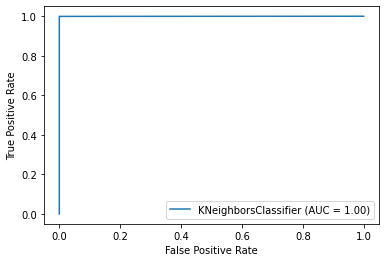

In [23]:
plot_roc_curve(cv.best_estimator_, X_test, y_test)
plt.show() 